In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_path = ('../../data_folder/Training/')
test_path = ('../../data_folder/Testing/')

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transform),
    batch_size=10, shuffle=True,
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),
    batch_size=10, shuffle=True
)

In [6]:
train_dataset = torchvision.datasets.ImageFolder(train_path,transform=transform)
print(len(train_dataset))

2870


In [7]:
test_dataset = torchvision.datasets.ImageFolder(test_path,transform=transform)
print(len(test_dataset))

394


In [8]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Linear(32*26*26, num_classes)
        #self.lsm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        #out = self.lsm(out)
        return out

In [9]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    model.train()
    correct = 0
    total = 0

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {accuracy:.2f}%")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [10]:
nn_light = ConvNet(num_classes=4).to(device)

In [11]:
train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light = test(nn_light, test_loader, device)

Epoch 1/10, Loss: 1.6575926050660605, Train Accuracy: 65.33%
Epoch 2/10, Loss: 0.543594072089378, Train Accuracy: 73.38%
Epoch 3/10, Loss: 0.3541372885038421, Train Accuracy: 78.28%
Epoch 4/10, Loss: 0.3192510750994106, Train Accuracy: 81.04%
Epoch 5/10, Loss: 0.22290452327522473, Train Accuracy: 83.23%
Epoch 6/10, Loss: 0.18658611916793746, Train Accuracy: 84.99%
Epoch 7/10, Loss: 0.0863341859303831, Train Accuracy: 86.67%
Epoch 8/10, Loss: 0.05000221925929699, Train Accuracy: 88.14%
Epoch 9/10, Loss: 0.06159852386197929, Train Accuracy: 89.21%
Epoch 10/10, Loss: 0.05763257283887428, Train Accuracy: 90.11%
Test Accuracy: 73.35%


In [13]:
import captum
from captum.attr import LRP

In [14]:
lrp = LRP(nn_light)
image_id = 0
X = test_dataset[image_id][0]
X = X.unsqueeze(0)
input = X.to(device)
attribution = lrp.attribute(input, target=test_dataset[image_id][1])


C:\Users\arink\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


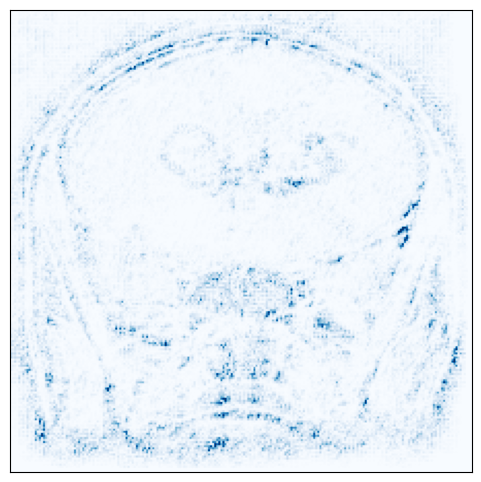

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [15]:
image = np.transpose(attribution.to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image)

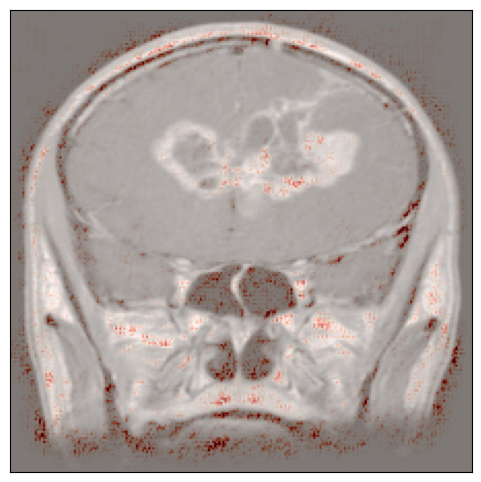

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [16]:
origin_image = np.transpose(test_dataset[0][0].to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image, method='blended_heat_map', cmap='Reds', original_image=origin_image)

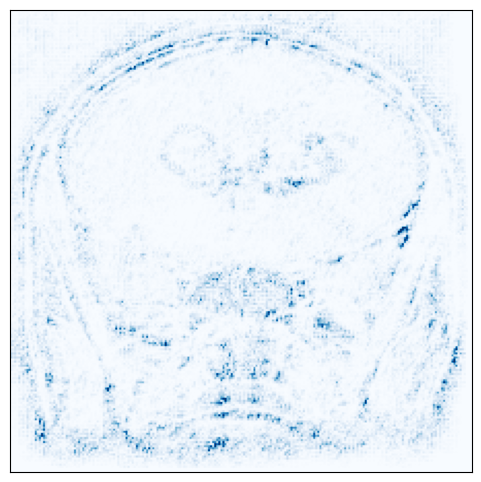

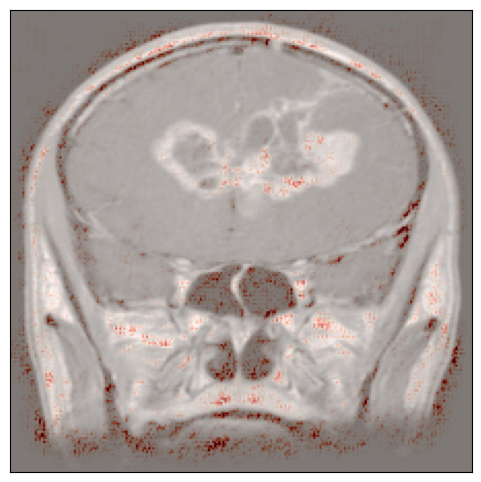

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [33]:
lrp = LRP(nn_light)
image_id = 0
X = test_dataset[image_id][0]
X = X.unsqueeze(0)
input = X.to(device)
attribution = lrp.attribute(input, target=test_dataset[image_id][1])
image = np.transpose(attribution.to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image)
origin_image = np.transpose(test_dataset[image_id][0].to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image, method='blended_heat_map', cmap='Reds', original_image=origin_image)

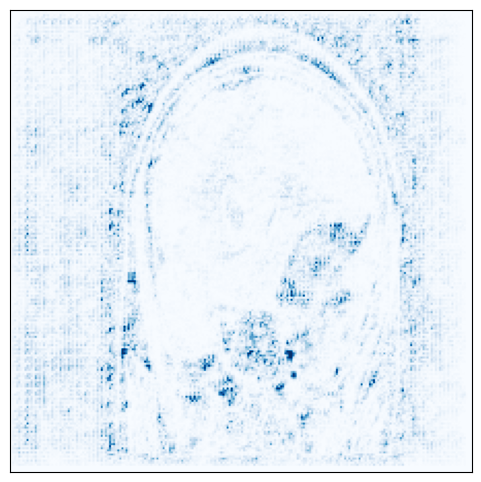

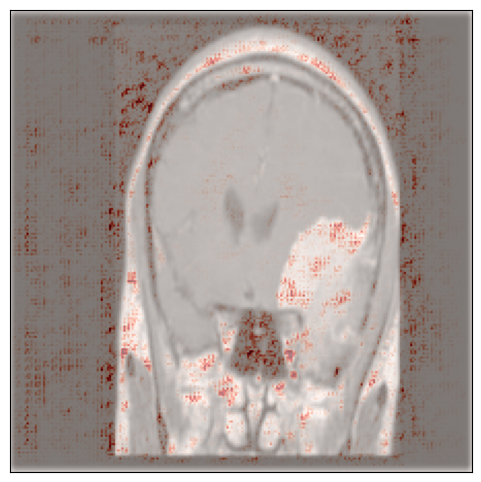

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [32]:
lrp = LRP(nn_light)
image_id = 100
X = test_dataset[image_id][0]
X = X.unsqueeze(0)
input = X.to(device)
attribution = lrp.attribute(input, target=test_dataset[image_id][1])
image = np.transpose(attribution.to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image)
origin_image = np.transpose(test_dataset[image_id][0].to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image, method='blended_heat_map', cmap='Reds', original_image=origin_image)

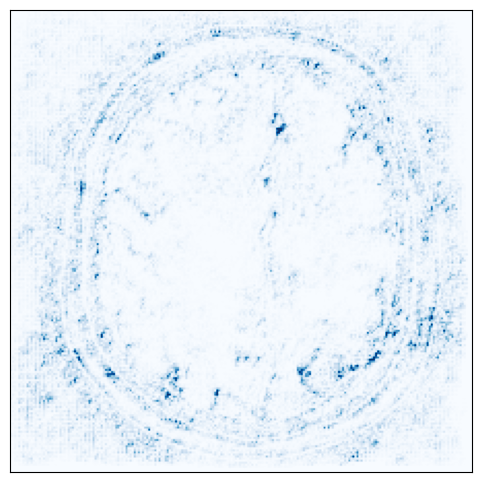

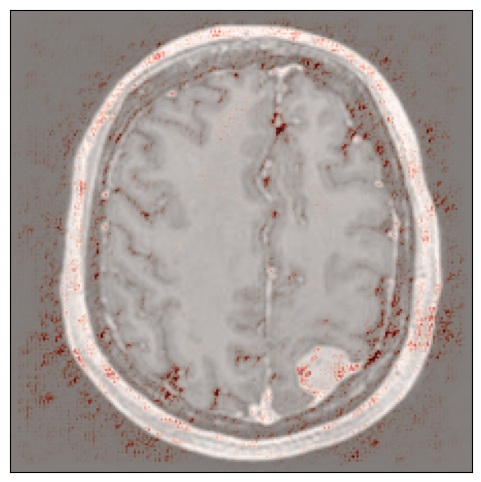

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [34]:
lrp = LRP(nn_light)
image_id = 200
X = test_dataset[image_id][0]
X = X.unsqueeze(0)
input = X.to(device)
attribution = lrp.attribute(input, target=test_dataset[image_id][1])
image = np.transpose(attribution.to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image)
origin_image = np.transpose(test_dataset[image_id][0].to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image, method='blended_heat_map', cmap='Reds', original_image=origin_image)

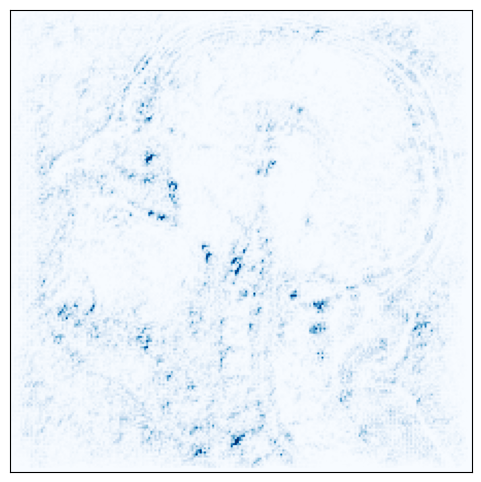

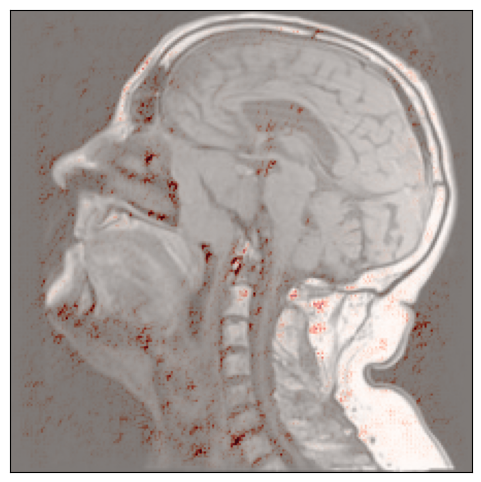

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [35]:
lrp = LRP(nn_light)
image_id = 300
X = test_dataset[image_id][0]
X = X.unsqueeze(0)
input = X.to(device)
attribution = lrp.attribute(input, target=test_dataset[image_id][1])
image = np.transpose(attribution.to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image)
origin_image = np.transpose(test_dataset[image_id][0].to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image, method='blended_heat_map', cmap='Reds', original_image=origin_image)

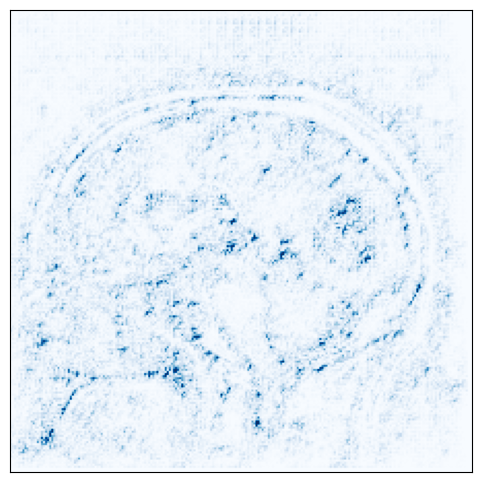

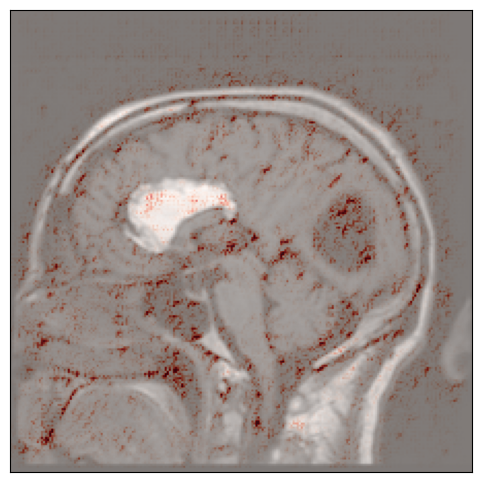

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [36]:
lrp = LRP(nn_light)
image_id = 50
X = test_dataset[image_id][0]
X = X.unsqueeze(0)
input = X.to(device)
attribution = lrp.attribute(input, target=test_dataset[image_id][1])
image = np.transpose(attribution.to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image)
origin_image = np.transpose(test_dataset[image_id][0].to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image, method='blended_heat_map', cmap='Reds', original_image=origin_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


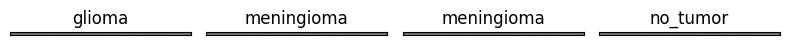

In [26]:
image_indexes = [0, 100, 200, 300]
NAMES = {0 : 'glioma', 1: 'meningioma', 2: 'no_tumor', 3: 'pituitary'}
attr = []
originals = []
titles = []
methods = []
sign = []
s = 'absolute_value'
method = 'blended_heat_map'
for i, image_id in enumerate(image_indexes):
    methods.append(method)
    sign.append(s)
    X = test_dataset[image_id][0]
    titles.append(NAMES[test_dataset[image_id][1]])
    X = X.unsqueeze(0)
    input = X.to(device)
    attribution = lrp.attribute(input, target=test_dataset[image_id][1])
    image = np.transpose(attribution.to('cpu').detach().numpy().squeeze(), (1, 2, 0))
    attr.append(image)
    origin_image = np.transpose(test_dataset[image_id][0].to('cpu').detach().numpy().squeeze(), (1, 2, 0))
    originals.append(origin_image)
    
for i in range(len(attr)):
    attr[i] = (attr[i] - attr[i].min()) / (attr[i].max() - attr[i].min())

_ = captum.attr.visualization.visualize_image_attr_multiple(attr, original_image=originals, methods=methods, signs=sign, titles=titles, fig_size=(8, 6))

#captum.attr.visualization.visualize_image_attr(image, method='blended_heat_map', cmap='Reds', original_image=origin_image, plt_fig_axis=(fig, axes[i, 1]))
